# Data Analysis

Referências: 
- [Exploratory Data Analysis for Natural Language Processing: A Complete Guide to Python Tools](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools)
- [Word Cloud showing several ' amongst words and not sure why](https://stackoverflow.com/questions/67148707/word-cloud-showing-several-amongst-words-and-not-sure-why)
- [Sentiment Analysis of App Reviews: A Comparison of BERT, spaCy, TextBlob, and NLTK](https://francisgichere.medium.com/sentiment-analysis-of-app-reviews-a-comparison-of-bert-spacy-textblob-and-nltk-9016054d54dc)
- [Sentiment Classification using SpaCy](https://www.kaggle.com/code/krutarthhd/sentiment-classification-using-spacy)
- [Building a Sentiment Analysis Model Using spaCy: A Practical Guide](https://mysteryweevil.medium.com/building-a-sentiment-analysis-model-using-spacy-a-practical-guide-261d881e5dcb)
- [spacytextblob](https://spacy.io/universe/project/spacy-textblob)

## Local imports config

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

## General imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import pprint
import seaborn as sns


from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from transformers import BertTokenizer
from utils.plot_config import PlotConfig
from wordcloud import WordCloud

In [3]:
BERTIMBAU_MODEL_PATH = "neuralmind/bert-base-portuguese-cased"

In [4]:
TRANSLATION_TABLE_SPECIAL_CHARACTERS = str.maketrans("", "", punctuation)

In [5]:
reviews_df = pd.read_csv("../data_preparation/glassdoor_reviews_annotated.csv")

In [6]:
reviews_df.head()

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",2023-12-15,5.0,1,0
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,2023-12-15,5.0,0,1
2,74420027,Tecnomapas,Analista Desenvolvedor,Ex-freelancer,Equipe bem prestativa e ótima de se trabalhar.,2023-03-11,4.0,1,0
3,74420027,Tecnomapas,Analista Desenvolvedor,Ex-freelancer,Modo home office ainda tem que ser melhorado.,2023-03-11,4.0,-1,0
4,60212043,Tecnomapas,Funcionário confidencial,"Ex-funcionário(a), menos de um ano",Única vantagem era o trabalho ser home office,2022-02-24,1.0,0,1


In [7]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2532 entries, 0 to 2531
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        2532 non-null   int64  
 1   company          2532 non-null   object 
 2   employee_role    2532 non-null   object 
 3   employee_detail  2532 non-null   object 
 4   review_text      2532 non-null   object 
 5   review_date      2532 non-null   object 
 6   star_rating      2532 non-null   float64
 7   sentiment        2532 non-null   int64  
 8   annotated        2532 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 178.2+ KB


In [8]:
len(reviews_df["company"].value_counts())

22

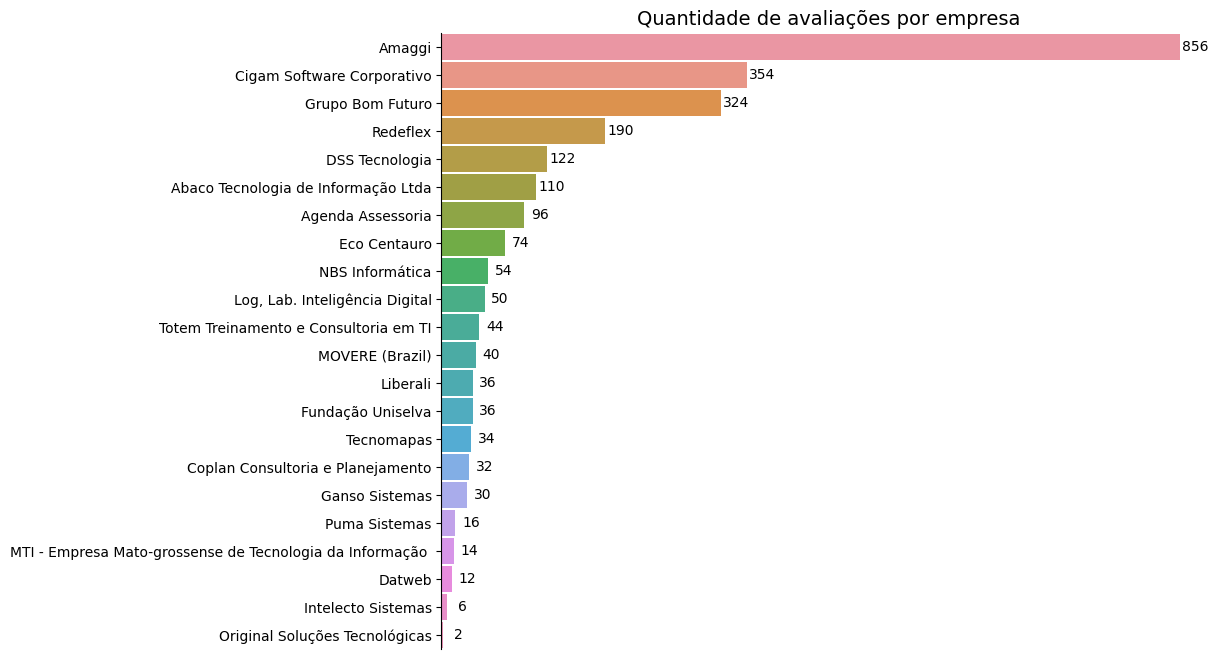

In [9]:
reviews_per_company_df = reviews_df["company"].value_counts().reset_index()
# reviews_per_company_df.columns = ["Empresa", "Quantidade de Avaliações"]

fig, ax = plt.subplots(1, figsize=(10, 8))
bars = sns.barplot(
    data=reviews_per_company_df,
    x="count",
    y="company",
    orient="h",
    ax=ax,
    width=0.9,
)

for p in ax.patches:
    bars.annotate(
        text=f"{int(p.get_width())}",
        xy=(p.get_width() + 10, p.get_y() + p.get_height() / 2),
        ha="center",
        va="center",
        fontsize=10,
        color="black",
        xytext=(5, 0),
        textcoords="offset points",
    )

sns.despine(top=True)
sns.despine(right=True)
sns.despine(bottom=True)

ax.set_xlabel("")
ax.set_xticks([])

ax.set_ylabel("")

ax.set_title(
    "Quantidade de avaliações por empresa",
    fontsize=14,
    y=1,
)


plt.savefig(
    "reviews_amount_by_company.png",
    transparent=True,
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [10]:
positive_reviews_df = reviews_df[reviews_df["sentiment"] == 1]
negative_reviews_df = reviews_df[reviews_df["sentiment"] == -1]
neutral_reviews_df = reviews_df[reviews_df["sentiment"] == 0]

## Analyzing review_text statistics

### Word Frequency

In [11]:
reviews_df["review_text_length"] = reviews_df["review_text"].str.len()

In [12]:
reviews_df.head()

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated,review_text_length
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",2023-12-15,5.0,1,0,60
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,2023-12-15,5.0,0,1,30
2,74420027,Tecnomapas,Analista Desenvolvedor,Ex-freelancer,Equipe bem prestativa e ótima de se trabalhar.,2023-03-11,4.0,1,0,46
3,74420027,Tecnomapas,Analista Desenvolvedor,Ex-freelancer,Modo home office ainda tem que ser melhorado.,2023-03-11,4.0,-1,0,45
4,60212043,Tecnomapas,Funcionário confidencial,"Ex-funcionário(a), menos de um ano",Única vantagem era o trabalho ser home office,2022-02-24,1.0,0,1,45


In [13]:
def plot_reviews_text_length_histogram(reviews_df):
    bins = 40

    axes = sns.histplot(data=reviews_df, x="review_text_length", bins=bins)

    plt.xlabel("Review Text Length")
    plt.ylabel("Frequency")
    plt.title("Histogram of Review Text")
    plt.show()

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


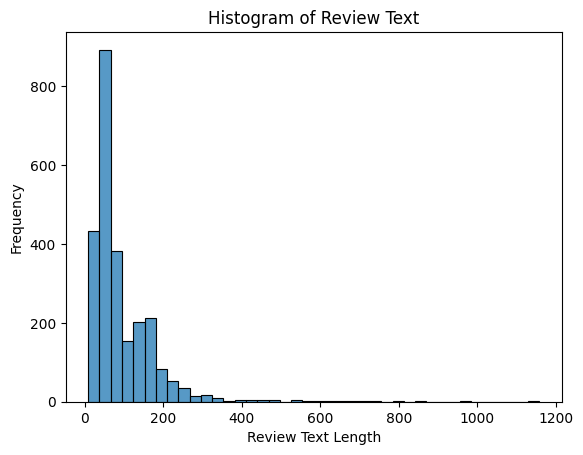

In [14]:
plot_reviews_text_length_histogram(reviews_df)

O Histograma mostra que a maior parte dos reviews tem cerca de 200 caracteres.

In [15]:
reviews_df[reviews_df["review_text"].str.len() > 1000]

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated,review_text_length
1313,32305292,Cigam Software Corporativo,Desenvolvedor De Software,"Ex-funcionário(a), mais de 3 anos",Diversos motivos me fazem criticar a CIGAM Pro...,2020-03-10,1.0,-1,0,1157


In [16]:
longest_text = reviews_df[reviews_df["review_text"].str.len() > 1000][
    "review_text"
].iloc[0]

In [17]:
len(longest_text)

1157

In [18]:
pprint.pprint(longest_text)

('Diversos motivos me fazem criticar a CIGAM Prodaly, mas acredito que os '
 'maiores são: pressão gigantesca da gerência (trabalhar madrugadas, finais de '
 'semana, etc); gerência não ouve os seus funcionários - sempre toma decisões '
 'por conta própria e que quase sempre se mostraram ruins ou erradas; '
 'linguagem de programação extremamente de nicho (linguagem magic), ou seja, '
 'se quiser seguir carreira nessa linguagem vai se aposentar na Prodaly, e se '
 'não bastasse ser de nicho, é uma linguagem defasada que pouco vai te ajudar '
 'no mercado de trabalho fora dali; gerência faz diversas reuniões apenas para '
 'esculachar os funcionários e dizer como eles são incompetentes; salários '
 'abaixo ou na média do mercado (só vai subir se você decidir que a empresa '
 'vale mais que sua vida e puxar o saco da gerência, pois é esse tipo de '
 'pessoa que eles querem contratar); Não pode utilizar fone de ouvido para '
 'programar; intervalo restritos há 10min, como se fosse uma esp

### Token frequency

In [19]:
tokenizer = BertTokenizer.from_pretrained(BERTIMBAU_MODEL_PATH)

c:\venvs\venv_sent_analysis\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [20]:
def count_tokens(review_text):
    tokens = tokenizer.tokenize(review_text)
    return len(tokens)

In [21]:
reviews_df["count_tokens"] = reviews_df["review_text"].apply(count_tokens)

In [22]:
reviews_df["count_tokens"].max()

257

In [23]:
reviews_df[reviews_df.index == reviews_df["count_tokens"].idxmax()]

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated,review_text_length,count_tokens
1313,32305292,Cigam Software Corporativo,Desenvolvedor De Software,"Ex-funcionário(a), mais de 3 anos",Diversos motivos me fazem criticar a CIGAM Pro...,2020-03-10,1.0,-1,0,1157,257


In [24]:
reviews_df[reviews_df.index == reviews_df["count_tokens"].idxmax()][
    "review_text"
].values[0]

'Diversos motivos me fazem criticar a CIGAM Prodaly, mas acredito que os maiores são: pressão gigantesca da gerência (trabalhar madrugadas, finais de semana, etc); gerência não ouve os seus funcionários - sempre toma decisões por conta própria e que quase sempre se mostraram ruins ou erradas; linguagem de programação extremamente de nicho (linguagem magic), ou seja, se quiser seguir carreira nessa linguagem vai se aposentar na Prodaly, e se não bastasse ser de nicho, é uma linguagem defasada que pouco vai te ajudar no mercado de trabalho fora dali; gerência faz diversas reuniões apenas para esculachar os funcionários e dizer como eles são incompetentes; salários abaixo ou na média do mercado (só vai subir se você decidir que a empresa vale mais que sua vida e puxar o saco da gerência, pois é esse tipo de pessoa que eles querem contratar); Não pode utilizar fone de ouvido para programar; intervalo restritos há 10min, como se fosse uma espécie de escola - sendo que trabalham com tecnolog

In [25]:
tokens = tokenizer.tokenize(
    reviews_df[reviews_df.index == reviews_df["count_tokens"].idxmax()][
        "review_text"
    ].values[0]
)

In [26]:
print(tokens)

['Diversos', 'motivos', 'me', 'fazem', 'critica', '##r', 'a', 'C', '##IG', '##AM', 'Pro', '##dal', '##y', ',', 'mas', 'acred', '##ito', 'que', 'os', 'maiores', 'são', ':', 'pressão', 'gigantes', '##ca', 'da', 'ger', '##ência', '(', 'trabalhar', 'madrugada', '##s', ',', 'finais', 'de', 'semana', ',', 'etc', ')', ';', 'ger', '##ência', 'não', 'ouve', 'os', 'seus', 'funcionários', '-', 'sempre', 'toma', 'decisões', 'por', 'conta', 'própria', 'e', 'que', 'quase', 'sempre', 'se', 'mostraram', 'ru', '##ins', 'ou', 'er', '##radas', ';', 'linguagem', 'de', 'programação', 'extremamente', 'de', 'nic', '##ho', '(', 'linguagem', 'mag', '##ic', ')', ',', 'ou', 'seja', ',', 'se', 'quis', '##er', 'seguir', 'carreira', 'nessa', 'linguagem', 'vai', 'se', 'aposentar', 'na', 'Pro', '##dal', '##y', ',', 'e', 'se', 'não', 'bas', '##tasse', 'ser', 'de', 'nic', '##ho', ',', 'é', 'uma', 'linguagem', 'def', '##asa', '##da', 'que', 'pouco', 'vai', 'te', 'ajudar', 'no', 'mercado', 'de', 'trabalho', 'fora', 'dali

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='count_tokens', ylabel='Count'>

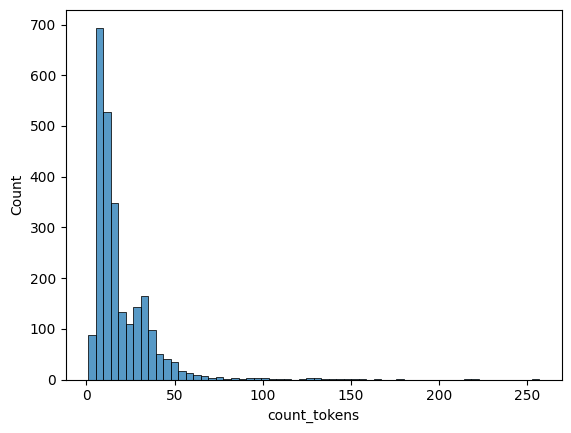

In [27]:
sns.histplot(data=reviews_df, x="count_tokens", bins=60)

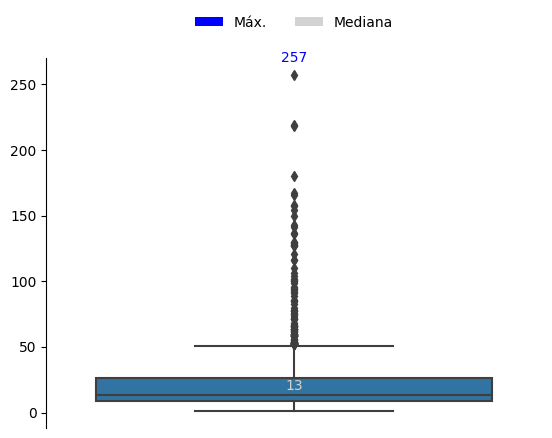

In [28]:
fig, ax = plt.subplots(1)
sns.boxplot(y=reviews_df["count_tokens"], ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

max_value = reviews_df["count_tokens"].max()
median_value = int(reviews_df["count_tokens"].median())

# Annotatation
ax.text(
    0,
    max_value + 10,
    f"{max_value}",
    horizontalalignment="center",
    color="blue",
    fontsize=10,
)

ax.text(
    0,
    median_value + 4.5,
    f"{int(median_value)}",
    horizontalalignment="center",
    color="#D3D3D3",
    fontsize=10,
)

# Axes config
ax.set_xlabel("")
ax.set_xticks([])

ax.set_ylabel("")

# Legend
max_tokens_patch = plt.Rectangle((0, 0), 1, 1, fc="blue")
median_tokens_patch = plt.Rectangle((0, 0), 1, 1, fc="#D3D3D3")

ax.legend(
    # title="",
    handles=[max_tokens_patch, median_tokens_patch],
    labels=["Máx.", "Mediana"],
    bbox_to_anchor=(0.5, 1.15),
    loc="upper center",
    edgecolor="1",
    ncols=2,
)

# ax.set_title(
#     "Quantidade de tokens por avaliação",
#     fontsize=11,
#     y=1.16
# )

plt.savefig(
    "tokens_by_reviews_boxplot.png",
    transparent=True,
    dpi=300,
    bbox_inches="tight",
)

plt.show()

### Reviews' word number

In [29]:
def plot_reviews_word_number_histogram(review_text_series):
    word_counts = review_text_series.str.split().map(lambda x: len(x))
    sns.histplot(word_counts, bins=30, kde=False)

    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.title("Histogram of Word Counts")
    plt.show()

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


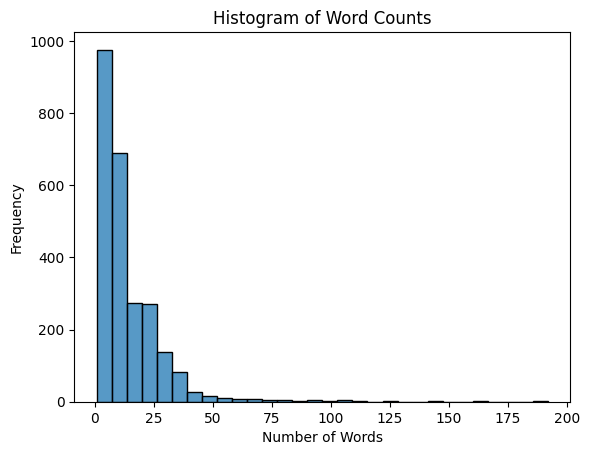

In [30]:
plot_reviews_word_number_histogram(reviews_df["review_text"])

O gráfico mostra que a maior parte dos reviews tem até 50 palavras

In [31]:
len(longest_text.split())

192

### Reviews' word average

In [32]:
def plot_reviews_word_average_histogram(review_text_series):
    word_average = (
        review_text_series.str.split()
        .apply(lambda x: [len(i) for i in x])
        .map(lambda x: np.mean(x))
    )

    sns.histplot(word_average, bins=80, kde=False)

    plt.xlabel("Average Word Length")
    plt.ylabel("Frequency")
    plt.title("Histogram of Average Word Length")
    plt.show()

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


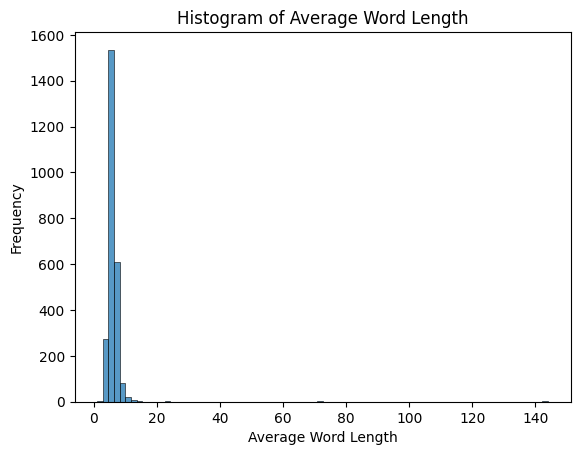

In [33]:
plot_reviews_word_average_histogram(reviews_df["review_text"])

O gráfico mostra que a maioria dos reviews tem média de 15 palavras.

### Most Frequently Stop Words

In [34]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
stopwords_portuguese = nltk.corpus.stopwords.words("portuguese")

In [36]:
corpus = []
review_text = reviews_df["review_text"].str.split().values.tolist()
corpus = [word for i in review_text for word in i]

In [37]:
dic = defaultdict(int)
for word in corpus:
    if word.lower() in stopwords_portuguese:
        dic[word] += 1

In [38]:
top_stopwords = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
top_stopwords_df = pd.DataFrame(top_stopwords, columns=["word", "frequency"])

In [39]:
top_stopwords_df.head()

,word,frequency
0,de,2136
1,e,1298
2,a,718
3,para,637
4,que,594


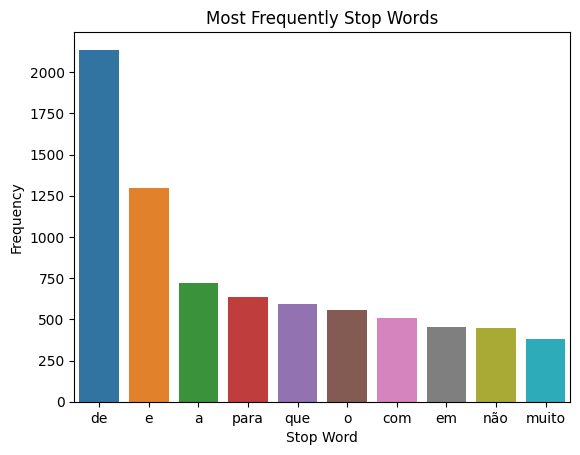

In [40]:
sns.barplot(data=top_stopwords_df, x="word", y="frequency")

plt.xlabel("Stop Word")
plt.ylabel("Frequency")
plt.title("Most Frequently Stop Words")
plt.show()

### Most Frequently Non Stop Words

In [41]:
counter = Counter(corpus)
most = counter.most_common()

top_non_stopwords = {}
for word, count in most[:40]:
    word_lower = word.lower()
    if word_lower not in stopwords_portuguese:
        if word_lower not in top_non_stopwords:
            top_non_stopwords[word_lower] = count
        else:
            top_non_stopwords[word_lower] += count

top_non_stopwords = list(top_non_stopwords.items())

In [42]:
top_non_stopwords_df = pd.DataFrame(top_non_stopwords, columns=["word", "frequency"])

In [43]:
top_non_stopwords_df.sort_values(by=["frequency"], ascending=False, inplace=True)

In [44]:
top_non_stopwords_df.head()

,word,frequency
0,empresa,697
1,trabalho,219
2,ambiente,201
3,plano,187
4,crescimento,150


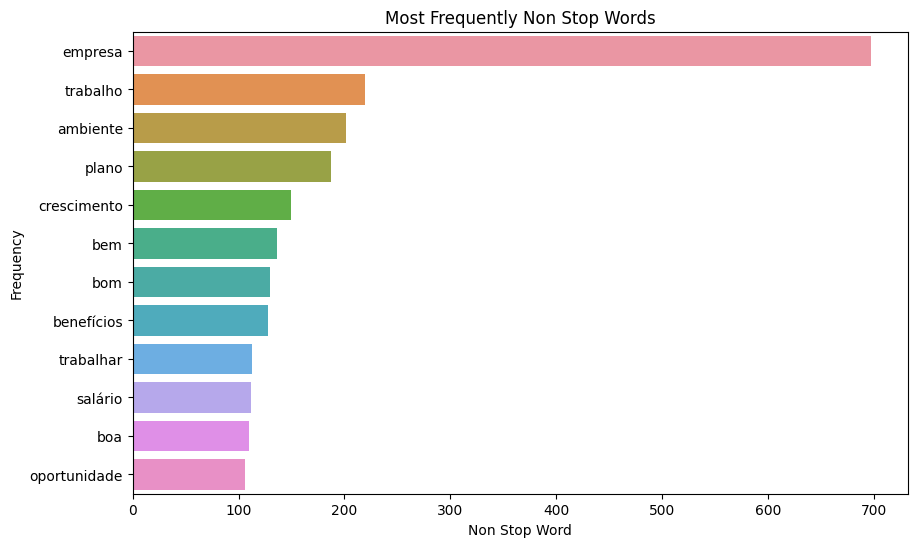

In [45]:
ax = plt.subplots(1, figsize=(10, 6))

ax = sns.barplot(data=top_non_stopwords_df, x="frequency", y="word")

plt.xlabel("Non Stop Word")
plt.ylabel("Frequency")
plt.title("Most Frequently Non Stop Words")
plt.show()

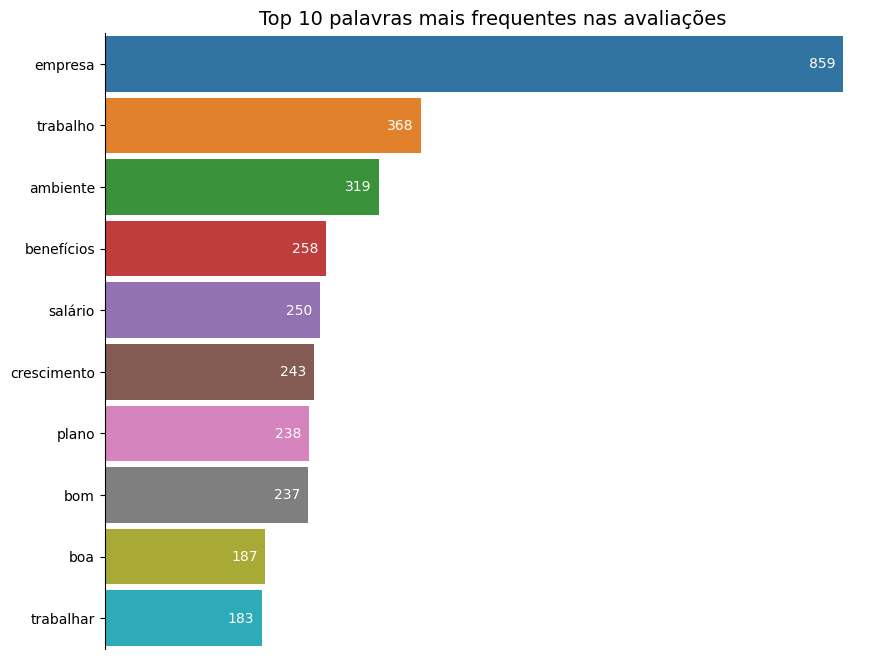

In [46]:
review_text = reviews_df["review_text"].str.split().values.tolist()
corpus = [word for i in review_text for word in i]

non_stopwords_corpus = []
for word in corpus:
    word_lower = word.lower()
    cleaned_word = word_lower.translate(TRANSLATION_TABLE_SPECIAL_CHARACTERS)
    if cleaned_word and cleaned_word not in stopwords_portuguese:
        non_stopwords_corpus.append(cleaned_word)

counter = Counter(non_stopwords_corpus)
most_common_words = counter.most_common(n=10)

words, counts = zip(*most_common_words)  # Unzip the words and counts
most_common_words_df = pd.DataFrame({"words": words, "counts": counts})

fig, ax = plt.subplots(1, figsize=(10, 8))

sns.barplot(
    data=most_common_words_df,
    x="counts",
    y="words",
    ax=ax,
    width=0.9,
    orient="h",
)

# Annotates
for p in ax.patches:
    ax.annotate(
        text=f"{p.get_width():.0f}",
        xy=(p.get_width(), (p.get_y() + p.get_height() / 2)),
        ha="center",
        va="center",
        fontsize=10,
        color="white",
        xytext=(-15, 0),
        textcoords="offset points",
    )

# Axes config
ax.set_xlabel("")

ax.set_xticks([])

ax.set_ylabel("")

ax.set_title(
    "Top 10 palavras mais frequentes nas avaliações",
    fontsize=PlotConfig.CHART_TITLE_FONT_SIZE,
    y=1.0,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

plt.savefig(
    "top_10_most_frequent_words.png",
    transparent=True,
    dpi=300,
    bbox_inches="tight",
)

plt.show()

### N-Grams

#### General N-Grams

In [47]:
def plot_top_ngrams_barchart(review_text, n_grams=2, top=10, title=None):
    vec = CountVectorizer(ngram_range=(n_grams, n_grams)).fit(review_text)
    bag_of_words = vec.transform(review_text)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    top_n_grams = words_freq[:top]
    x, y = map(list, zip(*top_n_grams))

    sns.barplot(x=y, y=x)
    plt.title(title, fontsize=20)

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


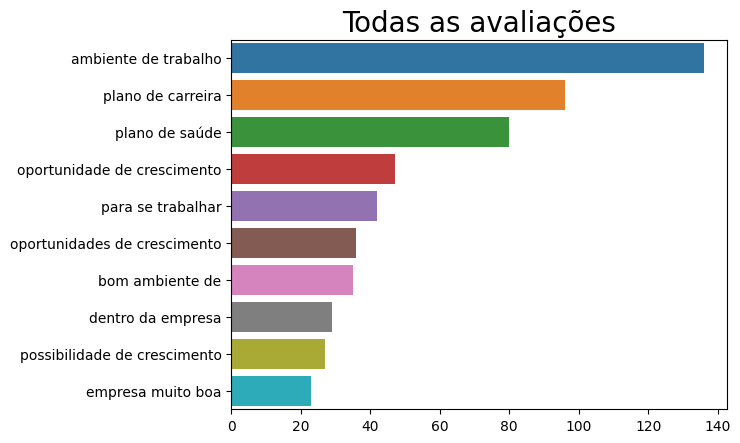

In [48]:
plot_top_ngrams_barchart(
    reviews_df["review_text"], n_grams=3, top=10, title="Todas as avaliações"
)

#### Positive N-Grams

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


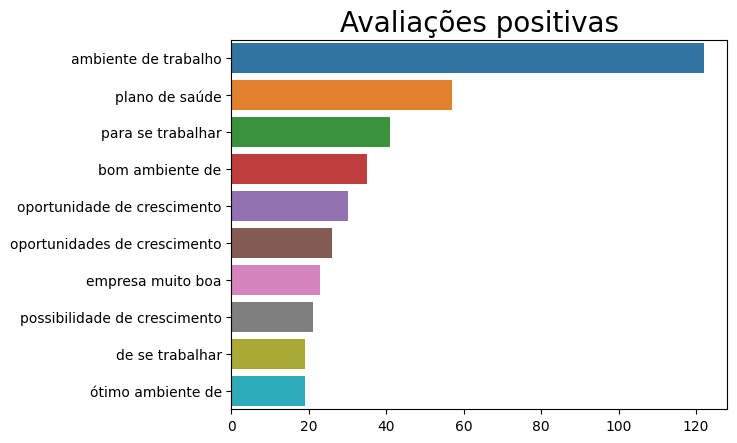

In [49]:
plot_top_ngrams_barchart(
    positive_reviews_df["review_text"],
    n_grams=3,
    top=10,
    title="Avaliações positivas",
)

#### Negative N-Grams

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


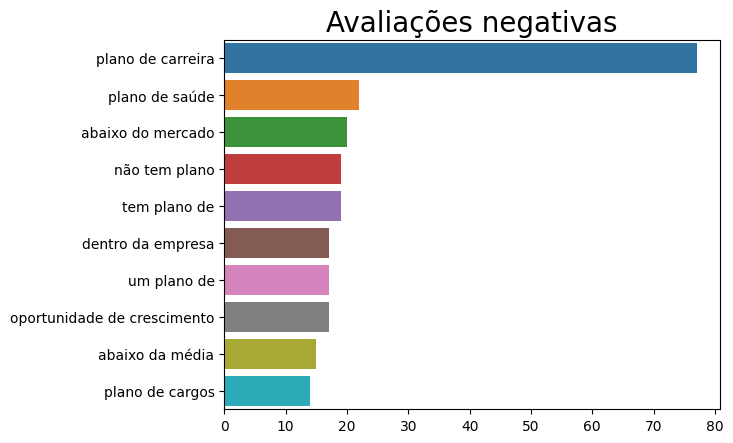

In [50]:
plot_top_ngrams_barchart(
    negative_reviews_df["review_text"],
    n_grams=3,
    top=10,
    title="Avaliações negativas",
)

#### Neutral N-Grams

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


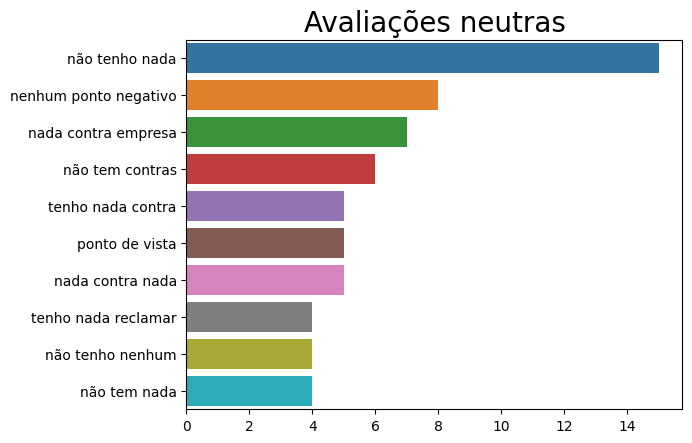

In [51]:
plot_top_ngrams_barchart(
    neutral_reviews_df["review_text"],
    n_grams=3,
    top=10,
    title="Avaliações neutras",
)

### Wordcloud

#### General WordCloud

In [52]:
corpus[:5]

['Companheirismo', 'entre', 'os', 'colegas,', 'oportunidade']

In [53]:
len(corpus)

37164

In [54]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [55]:
def print_wordcloud(corpus, title=None):
    non_stopwords_corpus = []
    for word in corpus:
        word_lower = word.lower()
        if (
            word_lower not in stopwords_portuguese
            and word_lower not in punctuation
        ):
            non_stopwords_corpus.append(word_lower)

    non_stopwords_corpus_str = " ".join(non_stopwords_corpus)

    wordcloud = WordCloud(
        background_color="white",
        random_state=103,
        max_words=150,
        width=1024,
        height=768,
    )

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis("off")

    plt.imshow(wordcloud.generate(str(non_stopwords_corpus_str)))
    plt.title(title, fontsize=20)
    plt.show()

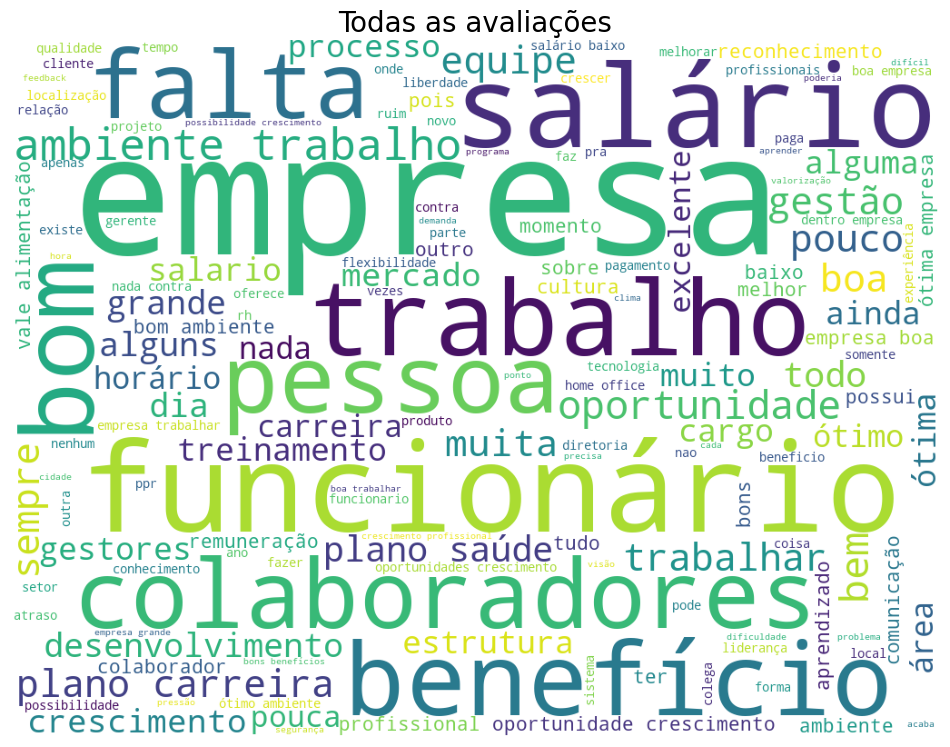

In [56]:
print_wordcloud(corpus, title="Todas as avaliações")

#### Positive WordCloud

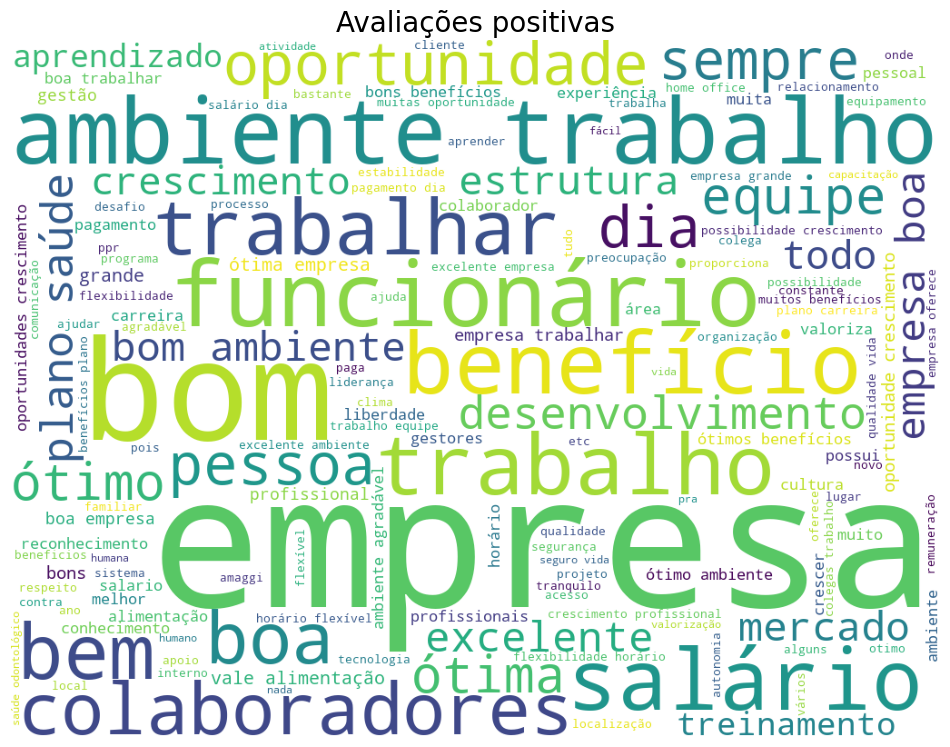

In [57]:
review_text = positive_reviews_df["review_text"].str.split().values.tolist()
corpus = [word for i in review_text for word in i]

print_wordcloud(corpus, title="Avaliações positivas")

#### Negative WordCloud

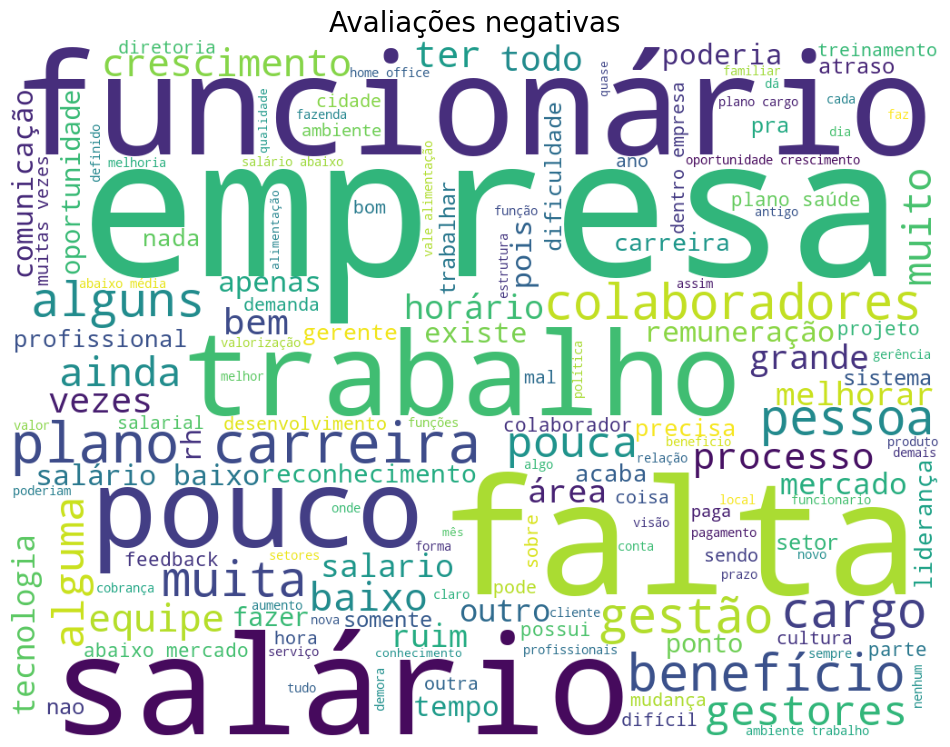

In [58]:
review_text = negative_reviews_df["review_text"].str.split().values.tolist()
corpus = [word for i in review_text for word in i]

print_wordcloud(corpus, title="Avaliações negativas")

#### Neutral WordCloud

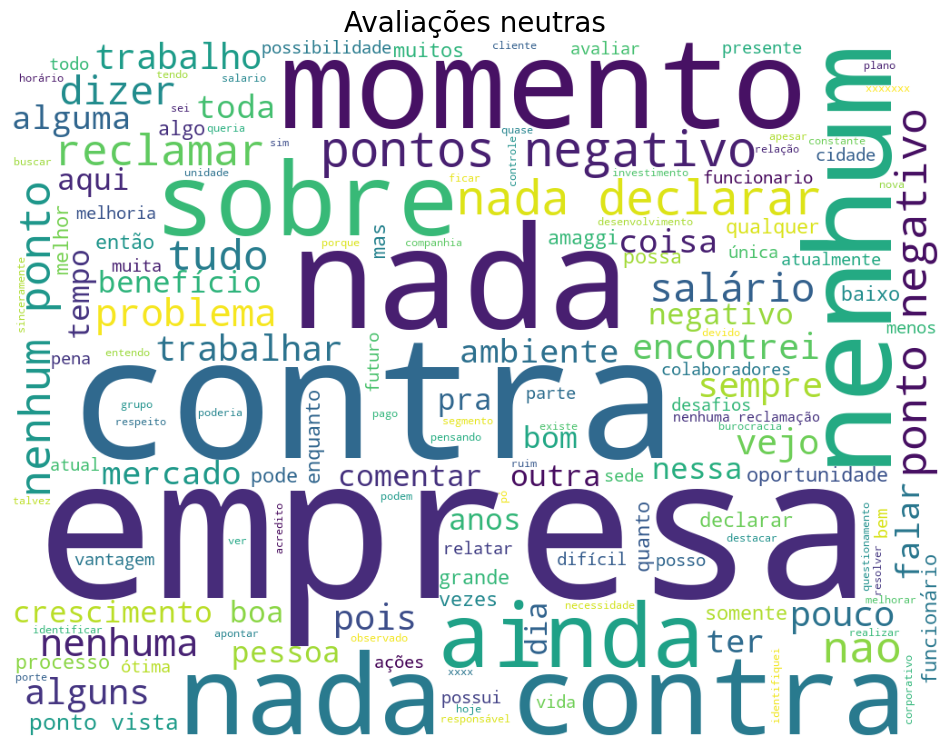

In [59]:
review_text = neutral_reviews_df["review_text"].str.split().values.tolist()
corpus = [word for i in review_text for word in i]

print_wordcloud(corpus, title="Avaliações neutras")

#### General WordCloud

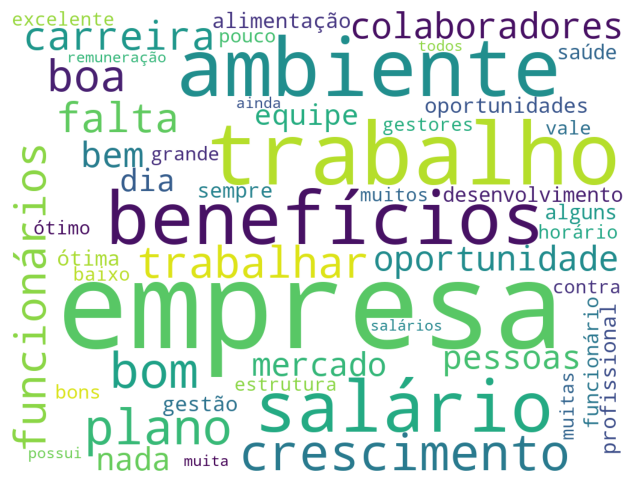

In [60]:
review_text = reviews_df["review_text"].str.split().values.tolist()
corpus = [word for i in review_text for word in i]

non_stopwords_corpus = []
for word in corpus:
    word_lower = word.lower()
    cleaned_word = word_lower.translate(TRANSLATION_TABLE_SPECIAL_CHARACTERS)
    if cleaned_word and cleaned_word not in stopwords_portuguese:
        non_stopwords_corpus.append(cleaned_word)

counter = Counter(non_stopwords_corpus)
most_common_words = counter.most_common(n=50)

wordcloud = WordCloud(
    background_color="white",
    random_state=PlotConfig.RANDOM_SEED,
    # max_words=10,
    width=1024,
    height=768,
)

fig, ax = plt.subplots(1, figsize=(10, 6))
plt.axis("off")

ax.imshow(wordcloud.generate_from_frequencies(dict(most_common_words)))

plt.savefig(
    "general_wordcloud.png",
    transparent=True,
    dpi=300,
    bbox_inches="tight",
)

plt.show()

## Analyzing sentiment statistics

In [61]:
sentiment_counts = reviews_df["sentiment"].value_counts().reset_index()
sentiment_counts.columns = ["sentiment", "count"]

In [62]:
sentiment_counts = sentiment_counts.sort_values(by="count", ascending=False)

In [63]:
sentiment_counts

,sentiment,count
0,1,1269
1,-1,1021
2,0,242


In [64]:
SENTIMENT_DICT = {0: "Neutral", 1: "Positive", -1: "Negative"}

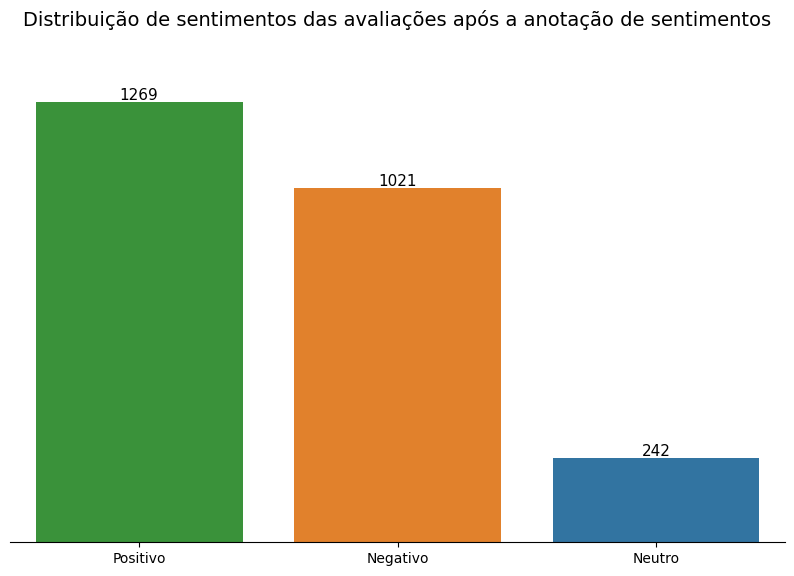

In [65]:
fig, ax = plt.subplots(1, figsize=(10, 6))

bars = sns.barplot(
    data=sentiment_counts,
    x=sentiment_counts.index,
    y="count",
    palette=[
        PlotConfig.POSITIVE_SENTIMENT_COLOR,
        PlotConfig.NEGATIVE_SENTIMENT_COLOR,
        PlotConfig.NEUTRAL_SENTIMENT_COLOR,
    ],
    ax=ax,
)

for p in bars.patches:
    bars.annotate(
        text=f"{int(p.get_height())}",
        xy=(p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=11,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )

ax.set_xlabel("")
ax.set_xticklabels(["Positivo", "Negativo", "Neutro"])

ax.set_yticks([])
ax.set_ylabel("")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.set_title(
    "Distribuição de sentimentos das avaliações após a anotação de sentimentos",
    fontsize=14,
    y=1.1,
)

plt.savefig(
    "sentiment_classes_after_annotation.png",
    transparent=True,
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [67]:
reviews_df["annotated"].value_counts()

annotated
0    2225
1     307
Name: count, dtype: int64

In [71]:
reviews_df[reviews_df["annotated"] == 1]["sentiment"].value_counts()

sentiment
 0    242
 1     49
-1     16
Name: count, dtype: int64